MPC trajectory tracking

In [1]:
import Pkg;
Pkg.activate(@__DIR__);
Pkg.instantiate()

Pkg.add("Convex")

using Libdl
using LinearAlgebra
using BlockDiagonals
import ForwardDiff as FD
using Plots
using CSV
using DataFrames
using Interpolations   
import ECOS  
using ProgressMeter
import MeshCat as mc 
using Test, Distributions
using Random


  Activating project at `~/CMU/24-774 Advanced Control Systems Integration/project/traj_gen_v2`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/CMU/24-774 Advanced Control Systems Integration/project/traj_gen_v2/Project.toml`
  No Changes to `~/CMU/24-774 Advanced Control Systems Integration/project/traj_gen_v2/Manifest.toml`


In [2]:
# load all files

data = CSV.read("heart_curve.csv", DataFrame; header=1) # trajectory waypoints that we will create a dynamically feasible trajectory for
#include(joinpath(@__DIR__, "CrazyflieParameters.jl")) # drone model parameters
include(joinpath(@__DIR__, "CrazyflieDynamics_noMagnet_v2.jl")) # drone dynamics, quaternion stuff
#include(joinpath(@__DIR__, "CrazyflieDynamics_noMagnet_original.jl")) # drone dynamics, quaternion stuff
include(joinpath(@__DIR__, "convex_mpc.jl")) # convex mpc setup
include(joinpath(@__DIR__, "visualization.jl")) # mesh cat visualizer


animate_Crazyflie (generic function with 1 method)

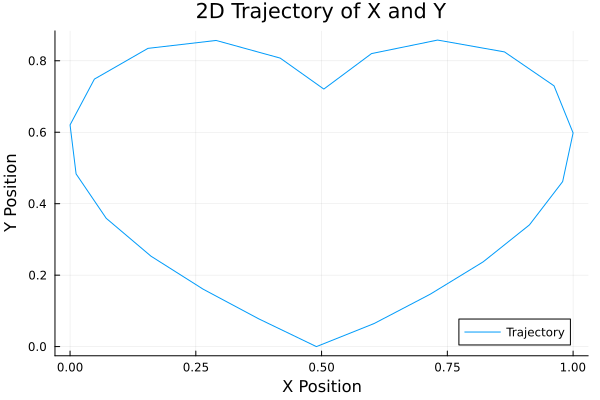

In [3]:
# input trajectory processing


# Access each column to build state vector
pos_x = data[1:end, :x] 
pos_y = data[1:end, :y]
pos_z = data[1:end, :z]
vel_x = data[1:end, :u]
vel_y = data[1:end, :v]
vel_z = data[1:end, :w]
angpos_phi = data[1:end, :phi]
angpos_theta = data[1:end, :theta]
angpos_psi = data[1:end, :psi]
angvel_p = data[1:end, :p]
angvel_q = data[1:end, :q]
angvel_r = data[1:end, :r]

# combine into state vector
Nsim= length(pos_x)
Xref = [zeros(12) for i = 1:Nsim]
# Loop through each timestep to build the state vector
for i in 1:Nsim
    Xref[i] = [pos_x[i], pos_y[i], pos_z[i], vel_x[i], vel_y[i], vel_z[i],
                angpos_phi[i], angpos_theta[i], angpos_psi[i], angvel_p[i], angvel_q[i], angvel_r[i]]
end

# plot the xy trajectory for visualization
plot(pos_x, pos_y, label="Trajectory", xlabel="X Position", ylabel="Y Position", title="2D Trajectory of X and Y")

# change into Xref with quaternions





In [5]:
# Crazyflie model parameters
model = (
    mass = 0.035,  # mass
    J = [1.66e-5 0.83e-6 0.72e-6; 0.83e-6 1.66e-5 1.8e-6; 0.72e-6 1.8e-6 2.93e-5],  # inertia
    g = 9.81,  # gravity
    thrustToTorque = 0.0008,  # thrust to torque ratio
    ℓ = 0.046/1.414213562,  # arm length
    PWM = 65535,  # PWM scale
    kt = 2.245365e-6*65535, # thrust coefficient
    km = 2.245365e-6*65535*0.0008, # moment coefficient
    freq =  100.0, #50.0, # control frequency
    dt = 1/100.0 # 50 Hz


    # testing
    #kt= 
)

# Access the value of `hertz` correctly
println(model.dt)  # Should print 0.02


# max thrust = 60 g


0.01


In [6]:
# Problem set up

nx1 = 13        # number of states (quaternion)
nx = 12         # number of states (linearized): x, y, z, Rodriguez 3-parameters (p, q, r), vx, vy, vz, wx, wy, wz
nu = 4          # number of controls

# Hovering state and control input
rg = [0.0; 0; 0.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
X̄ = [rg; qg; vg; ωg]
#xo = [rg; qg; vg; ωg]
Ū = (model.mass*model.g/model.kt/4)*ones(4)  # m = 30g and max thrust = 60g
#Uo = (model.mass*model.g/model.kt/4)*ones(4) 
@show X̄, Ū

# @show typeof(X̄), typeof(Ū)


#x0 = np.array([0.5, 1.3, -0.7, 0, 0, 0, 0, 0, 0, 0, 0, 0])


(X̄, Ū) = ([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5833333520642209, 0.5833333520642209, 0.5833333520642209, 0.5833333520642209])


([0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5833333520642209, 0.5833333520642209, 0.5833333520642209, 0.5833333520642209])

In [7]:
# Test input
# x = [zeros(3); 1.0; 0.0; 0.0; 0.0; zeros(6)]  # Position, quaternion, velocities, angular velocities
# u = ones(4) * 0.5  # Control inputs

# Model parameters
# model = (
#     mass = 0.03,
#     J = Diagonal([1e-6, 1e-6, 2e-6]),
#     g = 9.81,
#     thrustToTorque = 0.01,
#     ℓ = 0.046,
#     PWM = 255,
#     kt = 8.54858e-6,
#     km = 1.6e-2,
#     freq = 500,
#     hertz = 1 / 500,
# )

# result = quad_dynamics(model, x, u)
# @show result


In [ ]:
# no controller- just looking at the dynamics

Nsim = 100
x_all = [zeros(13) for i in 1:Nsim]
# simulate the dynamics with the zero controller
x = 1*X̄
#x = 1*xo
@show typeof(x)


for i in 1:Nsim
    x = quad_dynamics_rk4(x, Ū, model.dt)
    x_all[i] = x
end

# visualize_quad_state(x_all)

typeof(x) = Vector{Float64}


In [10]:
# LINEARIZATION

# linearized around a hover (with the controls being to counteract hover)
Anp = FD.jacobian(x->quad_dynamics_rk4(x,Ū, model.dt),X̄) # in the world frame
Bnp = FD.jacobian(u->quad_dynamics_rk4(X̄,u, model.dt),Ū);
# Anp = Array(E(qg)'*Am*E(qg))  # switch to body frame
# Bnp = Array(E(qg)'*Bm);

# println(size(Am))
# println(size(Anp))

# # linearized around a hover (with the controls being to counteract hover)
# Am = FD.jacobian(x->rk4(model,quadrotor_dynamics, x,Ū),X̄) # in the world frame
# Bm = FD.jacobian(u->rk4(model, quadrotor_dynamics,X̄,u),Ū);
# Anp = Array(E(qg)'*Am*E(qg))  # switch to body frame
# Bnp = Array(E(qg)'*Bm);

13×4 Matrix{Float64}:
 -1.13104e-6    1.24374e-6    1.13457e-6   -1.24726e-6
  1.12551e-6    1.23947e-6   -1.12677e-6   -1.23821e-6
  0.000210214   0.000210214   0.000210214   0.000210214
  0.0           0.0           0.0           0.0
 -0.00688387   -0.00758085    0.00689157    0.00757315
 -0.00691768    0.00760696    0.00693924   -0.00762852
  0.000493693  -0.000180591  -0.000696094   0.000382992
 -0.000452416   0.000497495   0.000453826  -0.000498905
  0.000450205   0.000495788  -0.000450708  -0.000495284
  0.0420429     0.0420429     0.0420429     0.0420429
 -2.75355      -3.03234       2.75663       3.02926
 -2.76707       3.04278       2.7757       -3.05141
  0.197477     -0.0722364    -0.278438      0.153197

In [11]:
# stability check (using infinite horizon LQR)
h= model.dt

# Riccati recursion on the linearized dynamics
#max_dev_x = [0.1; 0.1; 0.1;  0.5; 0.5; 0.03; 0.03;  0.5; 0.5; 0.5;  0.7; 0.7; 0.2]
max_dev_x = [0.05; 0.05; 0.05;  0.5; 0.5; 0.03; 0.03;  0.5; 0.5; 0.5;  0.7; 0.7; 0.2]
#max_dev_u = [0.5; 0.5; 0.5; 0.5]/6
max_dev_u = [0.1; 0.1; 0.1; 0.1]/6
Q = diagm(1 ./(max_dev_x.^2))
R = diagm(1 ./(max_dev_u.^2))
#R= diagm(0.01*ones(nu))
Qf = 1*Q


# K = zeros(4, 12)
# for i in 1:100
#     P = Q + Anp' * P * Anp - Anp' * P * Bnp * inv(R + Bnp' * P * Bnp) * Bnp' * P * Anp
#     K = inv(R + Bnp' * P * Bnp) * Bnp' * P * Anp
# end


# IHLQR- using the steady state P as Qn for the MPC controller
Kinf= Bnp'
max_iters= 1e6
P= deepcopy(Qf) #initialize p
for i= 1:max_iters
    Kinf = (R .+ Bnp' * P * Bnp)\  (Bnp' * P * Anp)
    P_recursion = Q + Anp' * P * Anp - Anp' * P * Bnp * Kinf
    
    if norm(P-P_recursion) <= 1e-6
        break
    end 
    # update P for next iteration
    P = 1*P_recursion
end
# ensure that Qn is hermitian 
Qf= 1*(P +P')/2;

##### TESTS #####

# check the norm of the nonlinear disretized dynamics to make sure they match at the equilibrium point
println("norm between X̄ and discretized dynamics= ", norm(X̄- quad_dynamics_rk4(X̄, Ū, model.dt)))
@assert norm(X̄- quad_dynamics_rk4(X̄, Ū, h)) < 1e-3

# check for system stability
eig= abs.(eigvals(Anp- Bnp*Kinf))
# Check if all eigenvalues are less than 1
if all(x -> x < 1.0, eig)
    println("The system is stable.")
else
    println("The system is unstable.")
end
println("eigenvalues= ",eig)


norm between X̄ and discretized dynamics= 7.237706648848374e-18
The system is stable.
eigenvalues= [2.220446049250313e-16, 0.8708561838149829, 0.8921527854481293, 0.8921527854481293, 0.9507725335246094, 0.9735039455772093, 0.9735039455772093, 0.975848713445053, 0.975848713445053, 0.9881499837532586, 0.9881499837532586, 0.9889785115462251, 0.9889785115462251]


In [12]:
# MPC setup
horizonLength = 100  # horizon length

# convert A to array column major
# A = Array{Float32}(cat(Anp..., dims=2))[:]

# A = cat(Anp..., dims=2)[:]
# B = cat(Bnp..., dims=2)[:]

rho = 0.1

# inequality constraints
# x_min = -1000. * ones(nx*horizonLength)  # state constraints
# x_max = 1000. * ones(nx*horizonLength)  # state constraints
# u_min = -Ū[1] * ones(nu*(horizonLength-1))  # force constraints
# u_max = (1-Ū[1]) * ones(nu*(horizonLength-1)) ; # force constraints
x_min = -1000. * ones(nx1)  # state constraints
x_max = 1000. * ones(nx1)  # state constraints
# u_min = -Ū[1] * ones(nu)  # force constraints
# #u_max = (1-Ū[1]) * ones(nu) ; # force constraints
# u_max = (Ū[1]) * ones(nu) ; # force constraints

u_min = -0.686 * ones(nu)  # force constraints
#u_max = (1-Ū[1]) * ones(nu) ; # force constraints
u_max = 0.686 * ones(nu) ; # force constraints

println("umin= ", u_min)
println("umax= ", u_max)

umin= [-0.686, -0.686, -0.686, -0.686]
umax= [0.686, 0.686, 0.686, 0.686]


In [ ]:
# trajectory generation

In [13]:
# MPC solve using convex mpc
Tfinal = 10.0
Nt = Int(Tfinal/model.dt)+1
Xref = [[1*cos(t)*sin(t);1*cos(t);0.063;1;zeros(9)] for t = range(-pi/2, 3*pi/2, length = Nt)]  
xref = [zeros(nx1) for i in 1:Nt] #this is delta x 
for k = 1:Nt
    x_ = Xref[k]
    # q = x_[4:7]
    # ϕ = qtorp(L(qg)'*q)   
    xref[k] .= [x_[1:3]-rg; x_[4:7]- qg; x_[8:10]-vg; x_[11:13]-ωg]
end

NSIM = Nt - horizonLength
x_all = [zeros(nx1) for i in 1:NSIM]

#tinympc = output_dir * "/build/tinympc/libtinympcShared" * os_ext  # Path to the compiled library

# x = Xref[1]  # initial state
# x[1:3] = Xref[1][1:3] + randn(3)/10  # initial position

x = Xref[1]  # initial state
x[1:3] = Xref[1][1:3] #+ randn(3)/10  # initial position
uhrz = (zeros(nu*(horizonLength-1)))  # List of control inputs in horizon
#ΔX_ref = [(X_ref[i] - X̄) for i = 1:length(X_ref)]




# simulation
u_current = [zeros(nu) for i in 1:NSIM]
@showprogress "simulating" for i in 1:NSIM

    # given a window of horizonLength timesteps, get current reference trajectory
    xref_horizon = Xref[i: (i+horizonLength-1)] #ΔX_ref[i: (i+ N_mpc-1)] 

    # println("A: ", typeof(Anp))
    # println("B: ", typeof(Bnp))
    # println("xref_horizon: ", typeof(xref_horizon))
    # println("x: ", typeof(x))
    # println("umin: ", typeof(u_min))
    # println("umax: ", typeof(u_max))
    # println("xmin: ", typeof(x_min))
    # println("xmax: ", typeof(x_max))
    # println("horizon length: ", typeof(horizonLength))
    # println("Q: ", typeof(Q))
    # println("R: ", typeof(R))
    # println("Qf: ", typeof(Qf))
    # println("Ubar: ", typeof(Ū))

    #ΔU_ref_horizon= ΔU_ref[i: (i+ N_mpc-1)]

    # Get the control input
    # call convex mpc controller with state estimate 
    u_current[i] = convex_mpc(Anp, Bnp, xref_horizon, x, u_min, u_max, x_min, x_max, horizonLength, Q, R, Qf, Ū)  #+ randn(n_inputs) * 0.01
    
    x = quad_dynamics_rk4(x, u_current[i], model.dt)

    #println(typeof(x))

    x_all[i] = 1*x

    ### simulate with the nonlinear dynamcis
    # X_sim[i+1] = rk4(model, quadrotor_dynamics, X_sim[i], U_sim[i], dt)
    # ΔX_sim[i+1]= X_sim[i+1] - X̄



    # u_current = mpc_controller(x, xref[i:i+N-1])

    # # Simulate the dynamics
    # x = quad_dynamics_rk4(x, u_current)

    # x_all[i] = 1*x
end



┌ Warning: Concatenating collections of constraints together with `+` or `+=` to produce a new list of constraints is deprecated. Instead, use `vcat` to concatenate collections of constraints.
└ @ Convex /Users/ashleykline/.julia/packages/Convex/QKz6m/src/deprecations.jl:129
┌ Warning: The keyword argument `silent_solver` in `Convex.solve!` has been deprecated in favor of `silent`.
└ @ Convex /Users/ashleykline/.julia/packages/Convex/QKz6m/src/solution.jl:93
simulating 100%|█████████████████████████████████████████| Time: 0:01:53


In [14]:
# println(u_current')
println(u_max)
println(u_min)

[0.686, 0.686, 0.686, 0.686]
[-0.686, -0.686, -0.686, -0.686]


In [15]:
# output to csv

# Convert vector to DataFrame
df = DataFrame(Value = x_all)

# Write DataFrame to CSV
CSV.write("output.csv", df)

"output.csv"

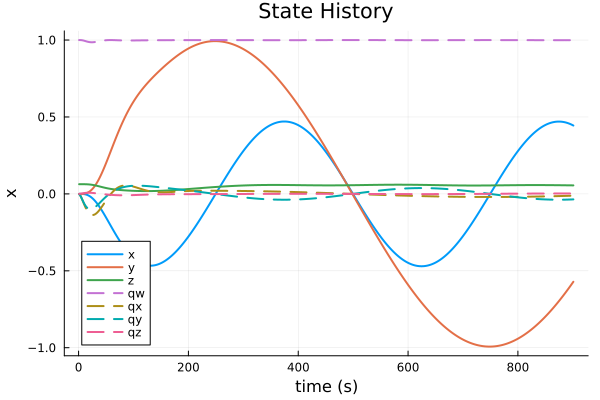

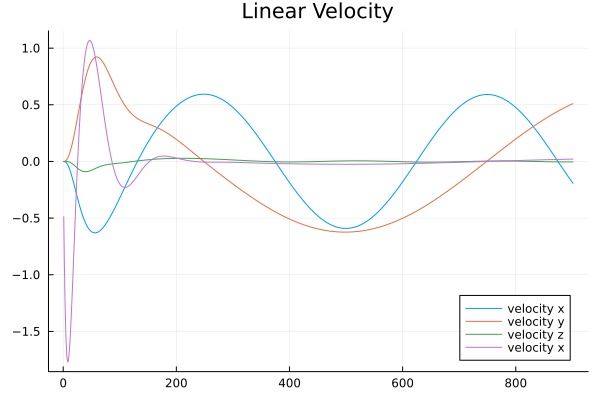

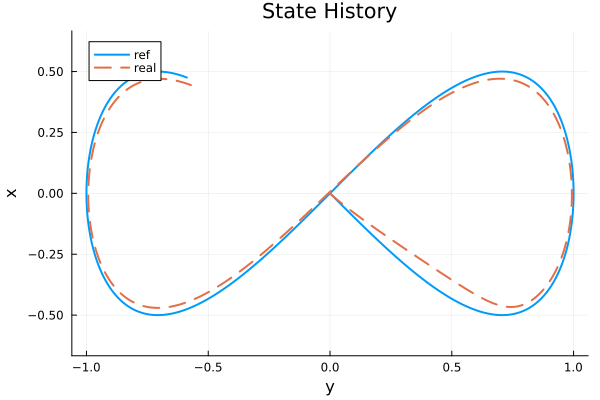

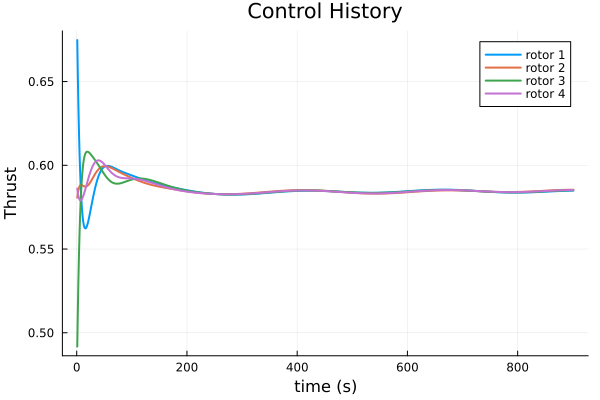

StackOverflowError: StackOverflowError:

In [ ]:
# visualization

visualize_quad_state(x_all)
visualize_quad_xy(x_all, xref[2:NSIM])
visualize_controls(u_current)

#animation- ********* this doesn't work yet
display(animate_Crazyflie(x_all, model.dt, xref))

questions for Arun
1. should the dynamics model change? If that changes, we need to make changes to the drone parameters themselves right?





Things to do:
1. smaller trajectory
2. add error graphs
3. get visualizer working'
4. switch the convex syntax?
